In [19]:
!pip install tensorflow pillow

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/SCAI_Neural_Network_Project/yolo_dataset
%ls

/content/drive/MyDrive/SCAI_Neural_Network_Project/yolo_dataset
images/  labels/  TrainDetectionModel.ipynb


In [12]:
# Import the required libraries
import os
import tensorflow as tf
from PIL import Image
import io

In [16]:
train_labels_directory = "labels/combined_train"
train_images_directory = "images/combined_train"

val_labels_directory = "labels/combined_valid"
val_images_directory = "images/combined_valid"

test_labels_directory = "labels/combined_test"
test_images_directory = "images/combined_test"

LABEL_MAP_DICT ={
    0: "no_gloves",
    1: "has_gloves"
    }

IMAGE_FORMAT = "jpg"

In [26]:
def create_tf_example(image_directory, label_directory):
  with tf.io.gfile.GFile(os.path.join(image_directory), 'rb') as fid:
    encoded_jpg = fid.read()
  image = Image.open(io.BytesIO(encoded_jpg))
  width, height = image.size
  filename = image_directory.split('/')[-1].encode('utf8')
  image_format = IMAGE_FORMAT.encode('utf8')
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  classes_text = []
  classes = []
  with open(label_directory, 'r') as label_file:
    for line in label_file.readlines():
      class_id, x_center, y_center, bound_width, bound_height = map(float, line.strip().split())
      xmin = (x_center - bound_width / 2) * width
      xmax = (x_center + bound_width / 2) * width
      ymin = (y_center - bound_height / 2) * height
      ymax = (y_center + bound_height / 2) * height

      xmins.append(xmin / width)
      xmaxs.append(xmax / width)
      ymins.append(ymin / height)
      ymaxs.append(ymax / height)

      class_id = int(class_id)
      classes_text.append(LABEL_MAP_DICT[class_id].encode('utf8'))
      classes.append(class_id + 1)

  tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        }))
  return tf_example




In [75]:
#For each file, create an encoded representating incorporating both the image and the bounding labels
writer = tf.io.TFRecordWriter("combined_test.tfrecord")

intended_directory = test_labels_directory

num_files = len(os.listdir(intended_directory))
index = 0

#pick which image/ label to use: train, val, or test.
for label_file in os.listdir(intended_directory):
  label_path = os.path.join(test_labels_directory, label_file)
  if not label_file.endswith(".txt"):
    continue
  image_file = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT
  image_path = os.path.join(test_images_directory, image_file)
  label_path = os.path.join(test_labels_directory, label_file)


  if not os.path.exists(image_path):
    print(f"Image file not found: {image_path}")
    continue

  tf_example = create_tf_example(image_path, label_path)
  writer.write(tf_example.SerializeToString())
  index += 1
  print(f"Processed {index}/{num_files} files")

writer.close()
print("tf record saved to combined_test.tfrecord")




Processed 1/530 files
Processed 2/530 files
Processed 3/530 files
Processed 4/530 files
Processed 5/530 files
Processed 6/530 files
Processed 7/530 files
Processed 8/530 files
Processed 9/530 files
Processed 10/530 files
Processed 11/530 files
Processed 12/530 files
Processed 13/530 files
Processed 14/530 files
Processed 15/530 files
Processed 16/530 files
Processed 17/530 files
Processed 18/530 files
Processed 19/530 files
Processed 20/530 files
Processed 21/530 files
Processed 22/530 files
Processed 23/530 files
Processed 24/530 files
Processed 25/530 files
Processed 26/530 files
Processed 27/530 files
Processed 28/530 files
Processed 29/530 files
Processed 30/530 files
Processed 31/530 files
Processed 32/530 files
Processed 33/530 files
Processed 34/530 files
Processed 35/530 files
Processed 36/530 files
Processed 37/530 files
Processed 38/530 files
Processed 39/530 files
Processed 40/530 files
Processed 41/530 files
Processed 42/530 files
Processed 43/530 files
Processed 44/530 fil

In [64]:
def parse_tfrecord(record_input):
  feature = {
      'image/encoded': tf.io.FixedLenFeature([], tf.string),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32)
        }
  parsed_record = tf.io.parse_single_example(record_input, feature)
  print(parsed_record)

  image = tf.image.decode_jpeg(parsed_record['image/encoded'],channels=3)
  image = tf.image.resize(image, [256, 256]) / 255.0

  bounding_boxes = tf.stack([
    tf.sparse.to_dense(parsed_record['image/object/bbox/ymin']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/xmin']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/ymax']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/xmax'])
  ], axis=1)


  return image, bounding_boxes

In [65]:
def load_dataset(record_path, batch_size, shuffle = False):
  dataset = tf.data.TFRecordDataset(record_path)
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
  if shuffle:
    dataset = dataset.shuffle(512)
  dataset = dataset.padded_batch(batch_size, padded_shapes=([256, 256, 3], [None, 4]))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [78]:
#train_dataset = load_dataset("combined_train.tfrecord", 16, shuffle = True)
#val_dataset = load_dataset("combined_val.tfrecord", 16)
test_dataset = load_dataset("combined_test.tfrecord", 16)

{'image/object/bbox/xmax': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:4", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:8", shape=(1,), dtype=int64)), 'image/object/bbox/xmin': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:5", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:9", shape=(1,), dtype=int64)), 'image/object/bbox/ymax': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:2", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:6", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:10", shape=(1,), dtype=int64)), 'i

In [71]:
class detector(tf.keras.Model):
  def __init__(self):
    super(detector, self).__init__()
    self.backbone = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 2, strides = 2, activation = 'relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 2, strides = 2, activation = 'relu'),
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    self.box_head = tf.keras.layers.Dense(4, activation = 'sigmoid')
  def call(self, x):
    return self.box_head(self.backbone(x))

def loss_fn(bboxes_true, box_preds):
    return tf.reduce_mean(tf.square(bboxes_true[:, 0] - box_preds))


In [74]:
model = detector()
model.compile(optimizer = 'adam', loss = loss_fn)

num_images = 3856
batch_size = 16
steps_per_epoch = num_images // batch_size

model.fit(train_dataset,validation_data=val_dataset, epochs = 10, steps_per_epoch = steps_per_epoch)

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 52s 205ms/step - loss: 0.0254 - val_loss: 0.0199
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0000e+00 - val_loss: 0.0199
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 51s 206ms/step - loss: 0.0200 - val_loss: 0.0195
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0000e+00 - val_loss: 0.0195
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 82s 336ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0000e+00 - val_loss: 0.0187
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - loss: 0.0190 - val_loss: 0.0181
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0000e+00 - val_loss: 0.0181
Epoch 9/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 210ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 10/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0000e+00 - val_loss: 0.0172


In [79]:
print("evaluating the dataset")
result = model.evaluate(test_dataset)
print(result)

evaluating the dataset
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0162
0.016986969858407974


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


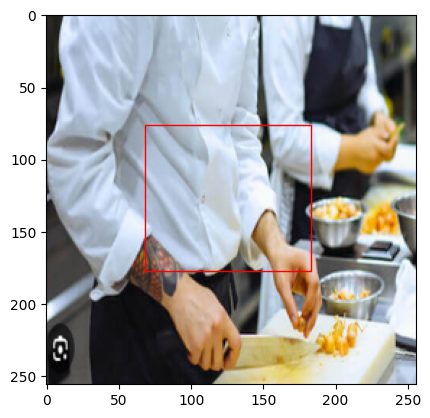

In [89]:
import matplotlib.pyplot as plt
import numpy as np

test_image = "images/combined_test/kitchen.jpeg"
img = Image.open(test_image).convert("RGB")
img = img.resize((256,256))
input_tensor = tf.convert_to_tensor(np.array(img)/255.0, dtype = tf.float32)
input_tensor = tf.expand_dims(input_tensor, axis = 0)

pred_bounds = model(input_tensor)
pred_bounds = pred_bounds[0].numpy()

img_width, img_height = img.size
ymin, xmin, ymax, xmax = pred_bounds

(ymin, xmin, ymax, xmax) = (int(ymin * img_height), int(xmin * img_width), int(ymax * img_height), int(xmax * img_width))


import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 1, edgecolor = 'r', facecolor = 'none')

ax.add_patch(rect)
plt.show()

In [93]:
model.save("mode1.keras")